In [101]:
using PyPlot
include("acoustic_solver.jl")
include("inverse_func.jl")
include("W2_func.jl")

compute_adj_source_core (generic function with 1 method)

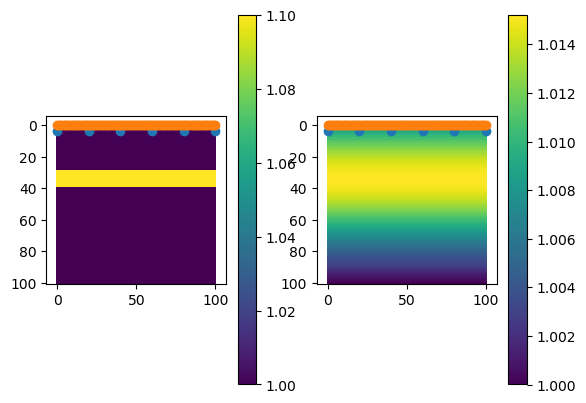

PyObject <matplotlib.collections.PathCollection object at 0x153d31710>

In [32]:
Nx = 101;
Ny = 101;
h = 0.01;

Nt = 1001;
Fs = 500;
dt = 1/Fs;
t = range(0, length=Nt, step=dt);

# source
# f = sin.(2*pi*5*t);
f = source_ricker(5,0.2,t)
source_num = 6
source = zeros(Nt, source_num);
for i = 1:source_num
    source[:,i] = f;
end
source_position = zeros(Int, source_num, 2);
for i = 1:source_num
    source_position[i,1] = 5;
    source_position[i,2] = 20*(i-1)+1;
end

# receiver
receiver_num = 101;
receiver_position = zeros(Int, receiver_num, 2);
for i = 1:receiver_num
    receiver_position[i,1] = 1
    receiver_position[i,2] = i
end

# model
c = 1*ones(Nx,Ny);
rho = 1*ones(Nx,Ny);
c[30:40,:] .= 1.1;

using ImageFiltering
c0 = imfilter(c, Kernel.gaussian(30));

subplot(121)
imshow(c); colorbar()
scatter(source_position[:,2].-1, source_position[:,1].-1)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1)

subplot(122)
imshow(c0); colorbar()
scatter(source_position[:,2].-1, source_position[:,1].-1)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1)

In [33]:
a = 1 ./ (c.^2 .* rho);
a0 = 1 ./ (c0.^2 .* rho);

### Simulate

In [34]:
@time received_data, wavefield = multi_solver(c, rho, Nx, Ny, Nt, h, dt, source, source_position, receiver_position);

 43.133493 seconds (2.81 M allocations: 62.906 GiB, 22.20% gc time)


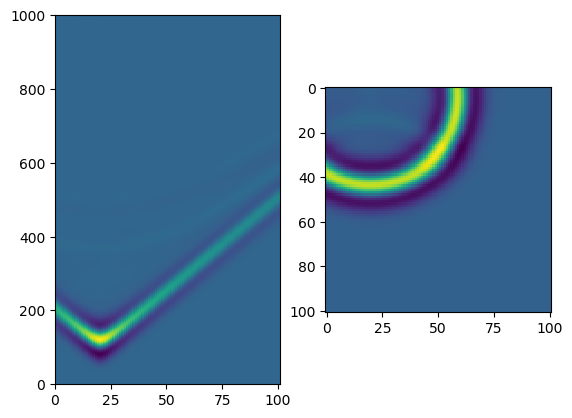

PyObject <matplotlib.image.AxesImage object at 0x14e7e7be0>

In [35]:
subplot(121); pcolor(received_data[:,:,2])
subplot(122); imshow(wavefield[:,:,300,2])

### Forward modelling

In [36]:
@time d, u =  multi_solver(c0, rho, Nx, Ny, Nt, h, dt, source, source_position, receiver_position);

 42.461565 seconds (1.64 M allocations: 62.852 GiB, 22.15% gc time)


### Adjoint method

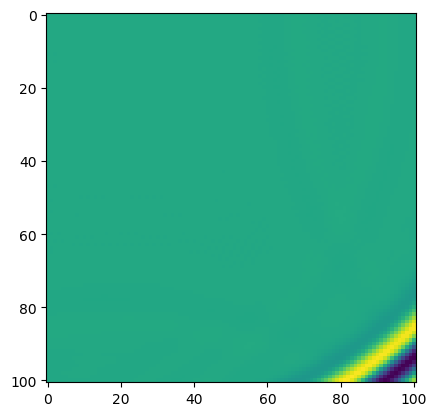

PyObject <matplotlib.image.AxesImage object at 0x17b710940>

In [58]:
utt = similar(u);
for i = 2:Nt-1
    utt[:,:,i,:] = (u[:,:,i+1,:]-2*u[:,:,i,:]+u[:,:,i-1,:]) ./ (2*dt);
end
utt[:,:,:,:] = utt[:,:,end:-1:1,:];
imshow(utt[:,:,300,2])

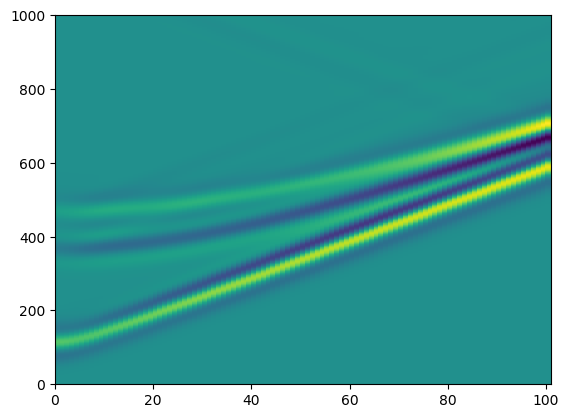

PyObject <matplotlib.collections.PolyCollection object at 0x14b6a3dd8>

In [38]:
# adjoint source
adj_source1 = d - received_data;
pcolor(adj_source1[:,:,1])

Test W2 adjoint

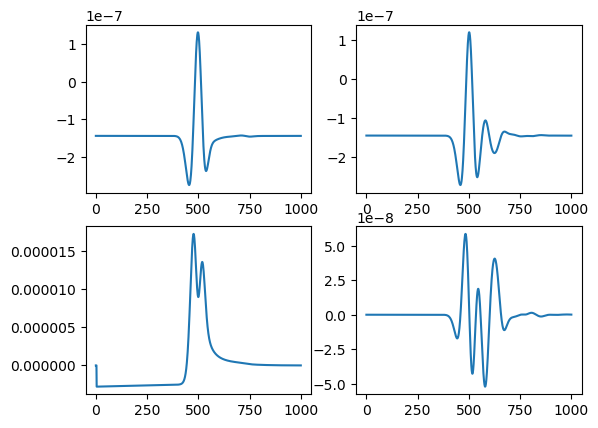

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x170517b00>

In [102]:
ind_receiver = 80; ind_source = 1;
f = d[:, ind_receiver, ind_source]
g = received_data[:, ind_receiver, ind_source]
fmin = minimum(f);
gmin = minimum(g);
f = f .+ 1.1*min(fmin,gmin)
g = g .+ 1.1*min(fmin,gmin)
sig = compute_adj_source_core(f, g, t, Nt, dt);

subplot(221); plot(f);
subplot(222); plot(g)
subplot(223); plot(sig)
subplot(224); plot(f-g)

In [100]:
sig

1001-element Array{Float64,1}:
 NaN                     
 NaN                     
 NaN                     
 NaN                     
  -2.7814619323063485e-6 
  -2.7808322054319436e-6 
  -2.780202478132138e-6  
  -2.7795727504069295e-6 
  -2.77894302225632e-6   
  -2.778313293680306e-6  
  -2.777683564678889e-6  
  -2.77705383525207e-6   
  -2.7764241053998456e-6 
   ⋮                     
   1.4916841596069354e-10
   1.2391272847070256e-10
   1.0109159189927468e-10
   8.065611458473497e-11 
   6.256790072939285e-11 
   4.679923752307714e-11 
   3.3331059266751815e-11
   2.2149505636616298e-11
   1.324209285049483e-11 
   6.594433378385046e-12 
   2.1881255114690653e-12
   0.0                   

In [64]:
adj_source = zeros(Nt, receiver_num, source_num)
for ind_source = 1:source_num
    for ind_receiver = 1:receiver_num
        f = d[:, ind_receiver, ind_source]
        g = received_data[:, ind_receiver, ind_source]
        fmin = minimum(f);
        gmin = minimum(g);
        f = f .+ 1.5*min(fmin,gmin)
        g = g .+ 1.5*min(fmin,gmin)
        adj_source[:,ind_receiver,ind_source] = compute_adj_source_core(f, g, t, Nt, dt);
    end
end

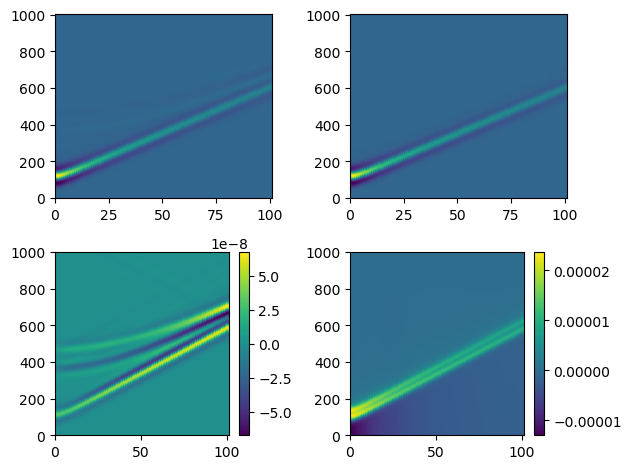

In [65]:
subplot(221); pcolor(received_data[:,:,1])
subplot(222); pcolor(d[:,:,1])
subplot(223); pcolor(adj_source1[:,:,1]); colorbar()
subplot(224); pcolor(adj_source[:,:,1]); colorbar()
tight_layout()

In [103]:
# backward wavefield
v = backward_solver(c0, rho, Nx, Ny, Nt, h, dt, adj_source, source_position, receiver_position);
v1 = backward_solver(c0, rho, Nx, Ny, Nt, h, dt, adj_source1, source_position, receiver_position);

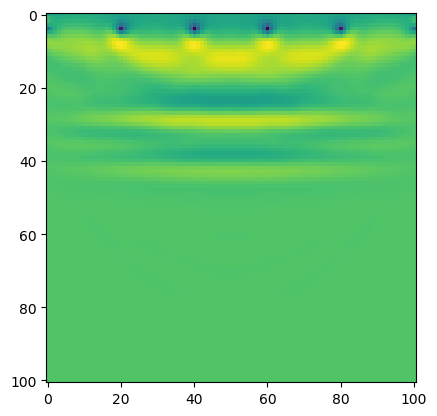

PyObject <matplotlib.image.AxesImage object at 0x1502696a0>

In [104]:
# Integration 
grad = zeros(Nx, Ny);
for i = 1:source_num
    g = utt[:,:,:,i] .* v1[:,:,:,i];
    g = sum(g, dims=3)
    grad += g[:,:,1];
end
imshow(grad)

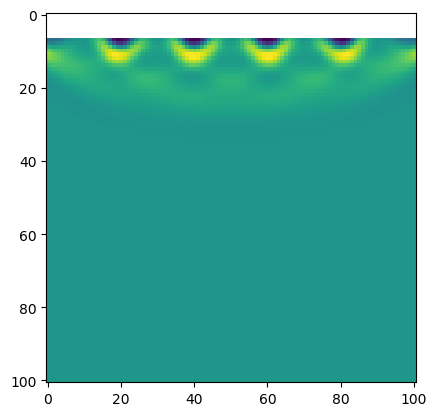

PyObject <matplotlib.image.AxesImage object at 0x157bae7f0>

In [106]:
grad = zeros(Nx, Ny);
for i = 1:source_num
    g = utt[:,:,:,i] .* v[:,:,:,i];
    g = sum(g, dims=3)
    grad += g[:,:,1];
end
# grad[findall(x->x==NaN,grad)] .= 0
imshow(grad)

In [67]:
i = 1
g = utt[:,:,:,i] .* v[:,:,:,i];

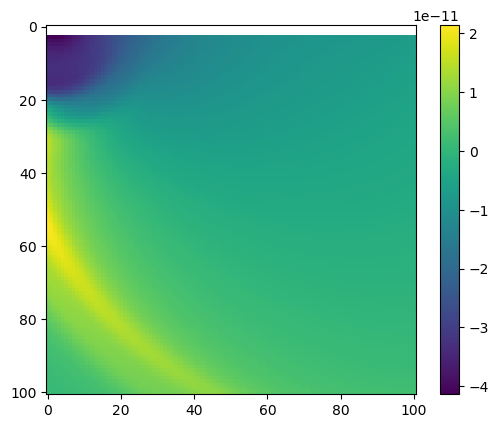

PyObject <matplotlib.colorbar.Colorbar object at 0x15b9a4438>

In [81]:
imshow(v[:,:,999,i]); colorbar() 

In [82]:
adj_source

1001×101×6 Array{Float64,3}:
[:, :, 1] =
 NaN            NaN            NaN            …  NaN            NaN          
 NaN            NaN            NaN               NaN            NaN          
 NaN            NaN            NaN               NaN            NaN          
 NaN            NaN            NaN               NaN            NaN          
  -1.29596e-5    -1.27685e-5    -1.23674e-5       -1.92382e-6    -1.92278e-6 
  -1.29596e-5    -1.27684e-5    -1.23674e-5   …   -1.9232e-6     -1.92216e-6 
  -1.29596e-5    -1.27684e-5    -1.23673e-5       -1.92259e-6    -1.92154e-6 
  -1.29595e-5    -1.27684e-5    -1.23673e-5       -1.92198e-6    -1.92091e-6 
  -1.29595e-5    -1.27683e-5    -1.23673e-5       -1.92136e-6    -1.92029e-6 
  -1.29594e-5    -1.27683e-5    -1.23672e-5       -1.92075e-6    -1.91967e-6 
  -1.29594e-5    -1.27682e-5    -1.23672e-5   …   -1.92014e-6    -1.91905e-6 
  -1.29593e-5    -1.27682e-5    -1.23671e-5       -1.91952e-6    -1.91842e-6 
  -1.29593e-5    -1.276